In [1]:
from ai import Model
from api import WeatherApi
from gpx import GPXParser

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import sklearn as sk

In [ ]:
api = WeatherApi()
parser = GPXParser(api)

# tracks = parser.parse_gpx_dir("data/bike")
tracks = [parser.parse_gpx_file("data/bike/cu_martoaga_la_deal.gpx")]
for track in tracks:
    name = track["filename"][0]
    GPXParser.plot_gpx(track)

data = pd.concat(tracks, ignore_index=True)

In [ ]:
display(data[data["elapsed_time"].diff() > 60])

In [ ]:
X = data[["incline", "elapsed_time", "temperature", "wind_course_diff", "wind_speed"]]
y = data["speed"]

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X.values, y, test_size=0.2
)

In [ ]:
model = Model.create(n_estimators=100)
model.fit(X_train, y_train)

In [ ]:
model.display_stats(X_train, y_train, X_test, y_test)

In [ ]:
for track in tracks:
    X = track[
        ["incline", "elapsed_time", "temperature", "wind_course_diff", "wind_speed"]
    ]
    y = track["speed"]
    print(model.score(X.values, y))

In [2]:
G = ox.graph_from_place("Prahova, Romania", network_type="bike")

In [3]:
G = ox.elevation.add_node_elevations_raster(G, "PH.tif")

In [ ]:
ox.plot_graph(G)

In [4]:
comarnic = ox.nearest_nodes(G, 25.633, 45.242)
tesila = ox.nearest_nodes(G, 25.719, 45.297)
mec = ox.nearest_nodes(G, 26.025, 44.9405)

In [ ]:
route = ox.nearest_nodes(G, data["longitude"], data["latitude"])

In [5]:
model = Model.load(".cache/model.pkl")

In [ ]:
from heapq import heappush, heappop


def model_estimate_segments_durations(
    G: nx.MultiDiGraph, src: int, dsts: list[int], time_at_src: float
) -> np.ndarray:
    """
    [Vectorized]
    Estimate the time taken to travel from a source node to its neighbours using
    the pretrained model.
    """

    src_edges = G[src]
    src_elev = G.nodes[src]["elevation"]

    lengths = []
    altitudes = []

    for dst in dsts:
        lengths.append(src_edges[dst][0]["length"])
        altitudes.append(G.nodes[dst]["elevation"])

    if len(lengths) == 0:
        return np.array([])

    lengths = np.array(lengths)
    altdiffs = np.array(altitudes) - src_elev
    inclines = altdiffs / np.array(lengths) * 100

    model_params = np.array(
        [
            inclines,
            np.full_like(inclines, time_at_src),
            np.full_like(inclines, 20),  # Assuming a constant temperature of 20°C
            np.zeros_like(inclines),  # Assuming no wind direction difference
            np.zeros_like(inclines),  # Assuming no wind speed
        ]
    ).T

    speeds = model.predict(model_params) / 3.6  # km/h -> m/s
    return lengths / speeds


def heuristic_estimate_segments_durations(
    G: nx.MultiDiGraph, src: int, dsts: list[int]
) -> np.ndarray:
    """
    [Vectorized]
    Estimate the time taken to travel from a source node to its neighbours
    using the Euclidean distance and maximum speed as a heuristic.
    """

    x1, y1 = G.nodes[src]["x"], G.nodes[src]["y"]
    x1s, y1s = np.full(len(dsts), x1), np.full(len(dsts), y1)

    x2s, y2s = [], []
    for dst in dsts:
        x2, y2 = G.nodes[dst]["x"], G.nodes[dst]["y"]
        x2s.append(x2)
        y2s.append(y2)

    x2s, y2s = np.array(x2s), np.array(y2s)

    distances = ox.distance.great_circle(y1s, x1s, y2s, x2s)
    return distances / 20  # Assuming max speed of 50 km/h


def astar(G: nx.MultiDiGraph, source: int, target: int) -> list[int]:
    # (estimated_total_time, elapsed_time, node, path)
    queue = [
        (
            heuristic_estimate_segments_durations(G, source, [target]),
            0,
            source,
            [source],
        )
    ]
    global visited  # debug
    visited = set()

    while len(queue) > 0:
        _, elapsed_time, node, path = heappop(queue)

        if node == target:
            return path

        if node in visited:
            continue

        visited.add(node)
        neighbors = list(G.neighbors(node))

        estimated_durations = model_estimate_segments_durations(
            G, node, neighbors, elapsed_time
        )
        elapsed_times = estimated_durations + elapsed_time
        estimated_totals = elapsed_times + heuristic_estimate_segments_durations(
            G, node, neighbors
        )

        for i, neighbor in enumerate(neighbors):
            neigh_estimated_total = estimated_totals[i]
            neigh_elapsed_time = elapsed_times[i]

            heappush(
                queue,
                (
                    neigh_estimated_total,
                    neigh_elapsed_time,
                    neighbor,
                    path + [neighbor],
                ),
            )

    return []

In [74]:
pth = astar(G, tesila, mec)

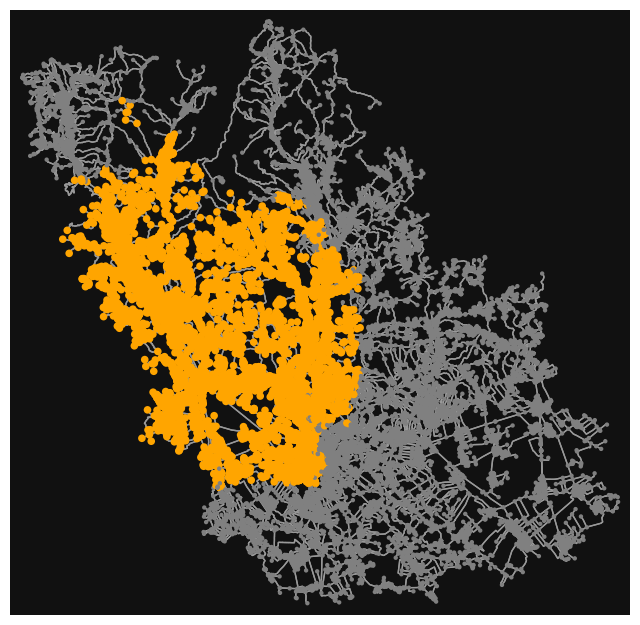

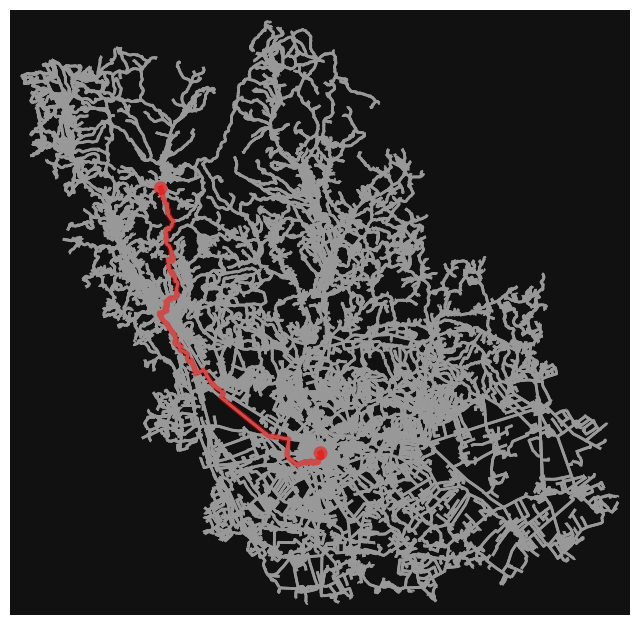

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [75]:
ox.plot_graph(
    G,
    node_color=["orange" if n in visited else "gray" for n in G.nodes],
    node_size=[30 if n in visited else 10 for n in G.nodes],
)

ox.plot_graph_route(
    G,
    pth,
    node_color="red",
    node_size=0,
    edge_linewidth=2,
    route_linewidth=4,
)

In [83]:
def estimate_route_time_distance(G: nx.MultiDiGraph, path: list[int]) -> float:
    total_time = 0.0
    total_distance = 0.0

    for i in range(len(path) - 1):
        src, dst = path[i], path[i + 1]
        edge_data = G[src][dst]
        length = edge_data[0]["length"]
        altdiff = G.nodes[dst]["elevation"] - G.nodes[src]["elevation"]
        incline = altdiff / length * 100
        speed = (
            model.predict(np.array([[incline, total_time, 20, 0, 0]]).reshape(1, -1))
            / 3.6
        )  # Convert km/h to m/s

        total_time += length / speed[0]
        total_distance += length

    return total_time, total_distance

In [86]:
time, dist = estimate_route_time_distance(G, pth)
print(time, dist, dist/time * 3.6)  

10153.850197786205 69809.3306519086 24.75057101016358
